Import Libraries

In [1]:
# # Install the latest JAXlib version.
# !pip install --upgrade -q pip jax jaxlib
# # Install Flax at head:
# # !pip install --upgrade -q git+https://github.com/google/flax.git
# !pip install flax
# # !pip install flax==0.5.1
# # !pip install evojax
# !pip install optax

In [2]:
import jax
import optax
import time
import matplotlib.pyplot as plt
from typing import Any, Callable, Sequence, Optional
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config
from scipy import array, power, diag, cos, sin, pi
# config.enable_omnistaging() # Linen requires enabling omnistaging
# from evojax.util import get_params_format_fn

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

PINNs Network

In [3]:
n_nodes = 8

class PINNs(nn.Module):
  """PINNs"""
  def setup(self):
    # hidden layers
    self.layers = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False),
                   nn.tanh,
                   nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh]
    # split layers
    self.splitx = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(1, use_bias=False)]
    self.splity = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(1, use_bias=False)]


  @nn.compact
  def __call__(self, inputs):
      # split the two variables, probably just by slicing
      t= inputs#[:,0:1]
      
      def get_xy(t):
        for i, lyr in enumerate(self.layers):
          t = lyr(t)
        # split layers
        hidden_x = self.splitx[0](t)
        hidden_x = self.splitx[1](hidden_x)
        hidden_y = self.splity[0](t)
        hidden_y = self.splity[1](hidden_y)
        # output layers
        x = self.splitx[2](hidden_x)
        y = self.splity[2](hidden_y)
        return x, y

      x, y = get_xy(t)

      # deriviatives needed to obtain are x_t, y_t, x_tt, y_tt
      def get_xy_t(get_xy, t):
        x_t, y_t = jacfwd(get_xy)(t)
        return x_t, y_t
      xy_t_vmap = vmap(get_xy_t, in_axes=(None, 0))
      x_t, y_t = xy_t_vmap(get_xy, t)
      x_t = x_t.reshape(-1,1)
      y_t = y_t.reshape(-1,1)
      def get_xy_tt(get_xy, t):
        x_tt, y_tt = hessian(get_xy)(t)
        return x_tt, y_tt
      xy_tt_vmap = vmap(get_xy_tt, in_axes=(None, 0))
      x_tt, y_tt = xy_tt_vmap(get_xy, t)
      x_tt = x_tt.reshape(-1,1)
      y_tt = y_tt.reshape(-1,1)
      action = jnp.hstack([x, y, x_t, y_t, x_tt, y_tt])   
      return action



In [4]:
model = PINNs()
# params = model.init(random.PRNGKey(0), jnp.zeros([2,1]))

In [5]:
seed = 0
key1, key2 = random.split(random.PRNGKey(seed))
a = random.normal(key1, [1,1]) # Dummy input
params = model.init(key2, a) # Initialization call
# jax.tree_map(lambda a: a.shape, params) # Checking output shapes
# model.apply(params, a)
# num_params, format_params_fn = get_params_format_fn(params)

Functions

In [6]:
# function to generate analytical solution
def f_x(t):
    return x0 + t*u0

def f_y(t):
    return y0 + t*v0 - 1./2*g*t**2

def f_t():
    return (vel0*sin(a0*pi/180) + sqrt((vel0*sin(a0*pi/180))**2 + 2*g*y0)) / g

# free fall
def terminal_vel():
    vinf = sqrt(2*m*g / (d*Cd*A))
    return vinf

def f_yfree(t, vinf):
    y_free = y0 - vinf**2/g*log(np.cosh(g*t/vinf))
    return y_free

Hyper parameters and data 

In [7]:
# specify planet to change g, d & a_T
# planet = {'earth': (9.8, 1.2, 2), 'mars': (3.7, 0, 4.5), 'moon': (1.6, 0, 10)}
planet = {'earth': (9.8, 0, 2), 'mars': (3.7, 0, 5.5), 'moon': (1.6, 0, 8)}
g, d, a_T = planet['mars']

# parameter related to flying ball (constant)
m = 0.6
r = 0.12
Cd = 0.54
A = pi*r**2

# initial condition @(x, y) position
x0, y0 = 0, 2
# initial condition @velocity
vel0 = 10       

# angle of projectile
a0 = 80

# initial velocity
u0 = vel0 * cos(a0*pi/180)
v0 = vel0 * sin(a0*pi/180)

# time domain: 0 - t_T
t_T = a_T    # let it fly..

t_fitness = 0

/tmp/ipykernel_3924614/3011757104.py:21: DeprecationWarning: scipy.cos is deprecated and will be removed in SciPy 2.0.0, use numpy.cos instead
  u0 = vel0 * cos(a0*pi/180)
/tmp/ipykernel_3924614/3011757104.py:22: DeprecationWarning: scipy.sin is deprecated and will be removed in SciPy 2.0.0, use numpy.sin instead
  v0 = vel0 * sin(a0*pi/180)


In [8]:
n_pde= 10000
n_ic= 1
t = jnp.linspace(0, t_T, n_pde).reshape(-1, 1)
data_pde = t
labels_pde_x = f_x(t)
labels_pde_y = f_y(t)

Loss Function

In [9]:
def make_mse_func(input):
  def mse(params):
    # Define the squared loss for a single pair (x,y)
    def squared_error(input):
        t = input[:,0:1]

        prediction = model.apply(params, input)
        x, y, x_t, y_t, x_tt, y_tt = prediction[:,0:1], prediction[:,1:2], prediction[:,2:3], prediction[:,3:4], prediction[:,4:5], prediction[:,5:6]


        # ground truth
        x_true = f_x(t)
        y_true = f_y(t)  
        _ic = jnp.where((jnp.equal(t, 0)), 1, 0)

        # initial conditions (which define the problem)
        ic_1 = jnp.sum(jnp.square((x_true-x)*_ic))/jnp.sum(_ic)
        ic_2 = jnp.sum(jnp.square((y_true-y)*_ic))/jnp.sum(_ic)

        ic_3 = jnp.sum(jnp.square((x_t-u0)*_ic))/jnp.sum(_ic)
        ic_4 = jnp.sum(jnp.square((y_t-v0)*_ic))/jnp.sum(_ic)

        # sum up all initial conditions
        ic_mse = ic_1 + ic_2 + ic_3 + ic_4

        # consider drag effect
        V = jnp.sqrt( (x_t)**2 + (y_t)**2 )
        C = 0.5*d*Cd*A/m
        R = C*V

        # PDE (physics laws):
        pde_x = x_tt + R*x_t
        pde_y = y_tt + R*y_t + g
        # exclude BC points
        _pde = jnp.where((jnp.equal(t, 0)), 0, 1)
        pde_x = pde_x*_pde
        pde_y = pde_y*_pde        
        pde_residuals_x = jnp.sum(jnp.square(pde_x))/jnp.sum(_pde)
        pde_residuals_y = jnp.sum(jnp.square(pde_y))/jnp.sum(_pde)
        pde_mse = pde_residuals_x + pde_residuals_y

        loss = pde_mse + ic_mse
        return loss
    return squared_error(input)
  return jax.jit(mse) # And finally we jit the result.

# Get the sampled loss
loss = make_mse_func(data_pde)

Weights Update

In [10]:
def update(params, opt_state):
    start = time.time()  
    loss_value, grad = jax.value_and_grad(loss)(params)
    end = time.time()
    global t_fitness
    t_fitness = t_fitness + (end-start)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value
update = jit(update)

Optimizer

In [11]:
alpha = 0.001
# optimizer = optax.adam(learning_rate=alpha) # Choose the method
optimizer = optax.sgd(learning_rate=alpha) # Choose the method
opt_state = optimizer.init(params)
loss_grad_fn = jax.value_and_grad(loss)

Training 

In [12]:
max_iters = 550000
loss_ls = []
t_training = []

runtime = 0
train_iters = 0
while (train_iters < max_iters) and (runtime < 60):
    start = time.process_time()
    params, opt_state, loss_value = update(params, opt_state)
    end = time.process_time()
    t_training.append(end-start)
    loss_ls.append(loss_value)
    runtime += (end-start)
    train_iters += 1


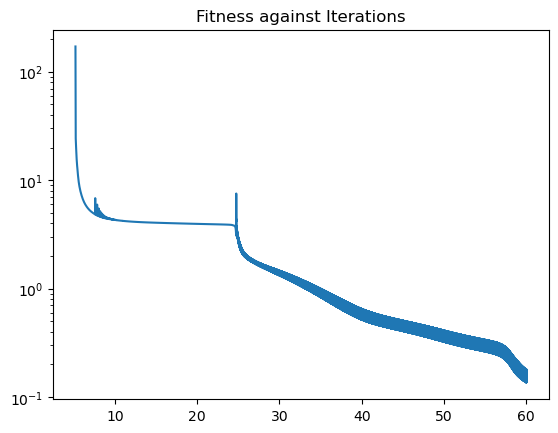

In [13]:
import numpy as np
training_ls = np.cumsum(t_training)

plt.plot(training_ls, loss_ls); plt.yscale('log');
# plt.xlim(800,1000)
# plt.ylim(-1e6,0)
plt.title('Fitness against Iterations')
plt.show()

In [14]:
import pandas as pd

df = pd.DataFrame({'Training Time': training_ls, 'Loss': loss_ls})
#df.to_csv('projectile_sgd_%d.csv'%(seed), index=False)
df

,Training Time,Loss
0,5.215438,171.04527
1,5.216351,156.13757
2,5.217064,145.70427
3,5.217736,137.84583
4,5.218336,131.5871
...,...,...
117649,59.998454,0.17878109
117650,59.998915,0.13647854
117651,59.999382,0.17875895
117652,59.999872,0.1364634


In [15]:
hello = PINNs()
prediction = hello.apply(params, data_pde)
x, y = prediction[:,0:1], prediction[:,1:2]

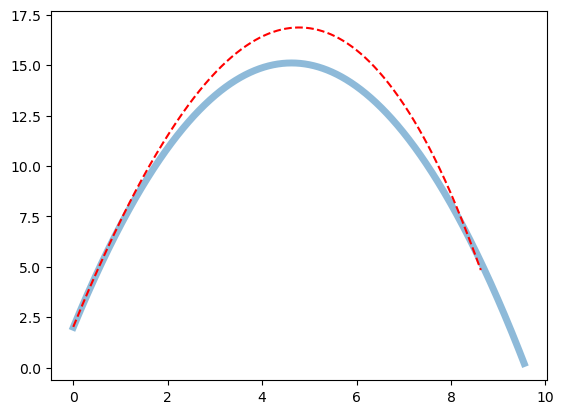

In [16]:
plt.plot(labels_pde_x, labels_pde_y, linewidth=5, alpha=.5);
plt.plot(x, y, linestyle='--', c='red');

In [17]:
np.mean((np.hstack([labels_pde_x, labels_pde_y]) - np.hstack([x, y]))**2)

2.9144795

In [18]:
np.save('projectile_sgd_60s', (x, y, labels_pde_x, labels_pde_y))